In [2]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
import numpy as np

import reviews_soli_driver
from reviews_soli import ReviewsSolicitation
from data_model import Feature

file_path = 'datasets/edmunds_reviews.csv'
lower_num_reviews = 800
num_polls = 100
dataset_profile = reviews_soli_driver.profile_dataset(file_path)
print(dataset_profile)

Dataset of 5 stars, with 501 products and 53440 reviews
# average feature ratings per product = 77.766
Global average sum of variance of feature = 0.032


Statistics of #reviews/product: min=1, max=1294, average=106.667, std=148.622, median=52.0


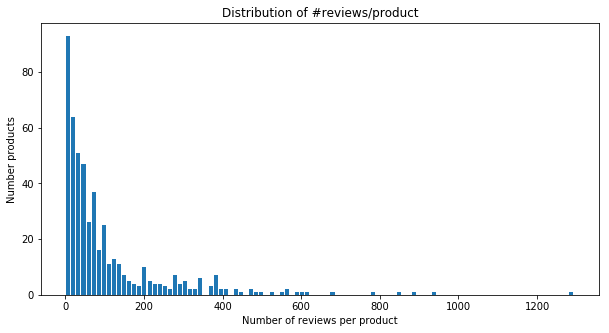

In [3]:
# Distribution of #reviews/product
temp = dataset_profile.num_reviews_per_product
print('Statistics of #reviews/product: min={min}, max={max}'
      ', average={average:.3f}, std={std:.3f}, median={median}' \
      .format(min=np.amin(temp), max=np.amax(temp),
              average=np.average(temp), std=np.std(temp), median=np.median(temp)))

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(dataset_profile.num_reviews_per_product, bins=100, rwidth=0.8)
ax.set_xlabel('Number of reviews per product')
ax.set_ylabel('Number products')
ax.set_title('Distribution of #reviews/product')
plt.show()

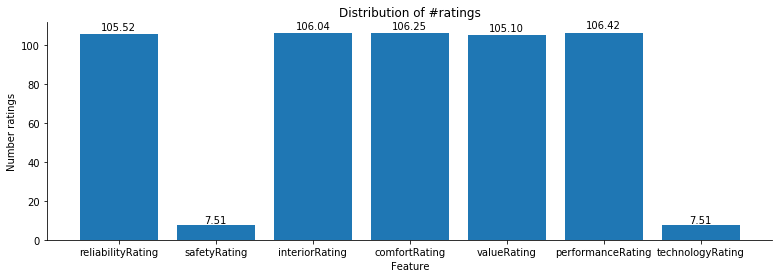

In [4]:
# Distribution of #feature_rating/product
fig, ax = plt.subplots(figsize=(13, 4))
features = list(dataset_profile.feature_to_ave_num_reviews_per_product.keys())
num_ratings = list(dataset_profile.feature_to_ave_num_reviews_per_product.values())
x_pos = np.arange(len(features))
rects = ax.bar(x_pos, num_ratings)

ax.set_xlabel('Feature')
ax.set_ylabel('Number ratings')
ax.set_title('Distribution of #ratings')
ax.set_xticks(x_pos)
ax.set_xticklabels(features)

for rect, num_rating in zip(rects, num_ratings):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.01*height,
            '{:.2f}'.format(num_rating), ha='center', va='bottom')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [53]:
def plot_ask_methods(sim_stats, criterion):
    #fig, ax = plt.subplots(figsize=(12, 7))
    fig, axarr = plt.subplots(1, 2, figsize=(18, 7),
                              sharex=True, sharey=True,
                              subplot_kw=dict(title='Cost change over polls',
                                              xlabel='Number of polls',
                                              ylabel=criterion))
    X = list(sim_stats[0].step_to_cost.keys())
    for i, ask_method in enumerate(ReviewsSolicitation.ask_methods):
        sim_stat = sim_stats[i]
        Y = list(sim_stat.step_to_cost.values())
        if ask_method.endswith('_gen'):
            axarr[1].plot(X, Y, label=ask_method)
        else:
            axarr[0].plot(X, Y, label=ask_method)

    for ax in axarr:
        ax.legend(loc='upper right')
    plt.show()

def plot_no_answer_count(ask_methods, no_answer_counts):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw={'title':'No answer count',
                                                       'xlabel':'#No answer'})
    y_pos = np.arange(len(ask_methods))
    rects = ax.barh(y_pos, no_answer_counts, align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(ask_methods)

    for rect, count in zip(rects, no_answer_counts):
        ax.text(rect.get_x() + rect.get_width() + 5,
                rect.get_y() + rect.get_height()/2,
                count, ha='right', va='center')
    plt.show()

Product: Honda-Accord-2004
*************Criterion: weighted_sum_dirichlet_variances with prior_count=77.77, prior_cost=0.03*************


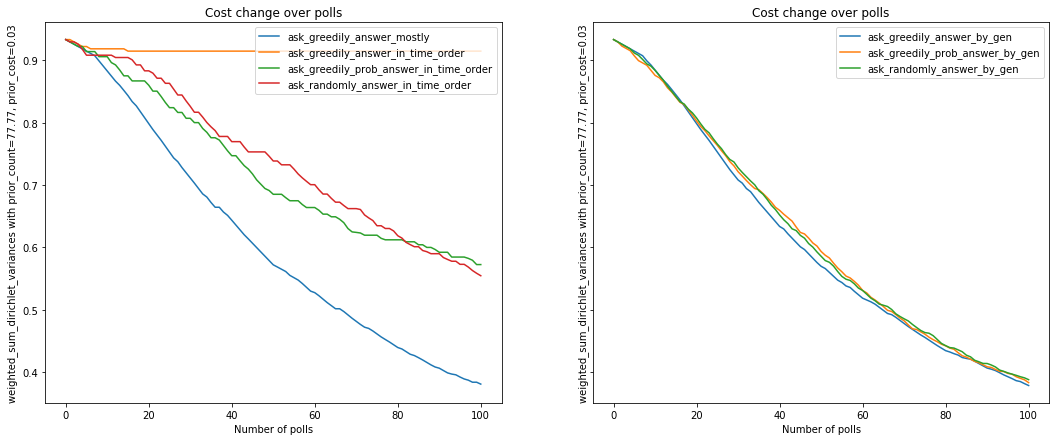

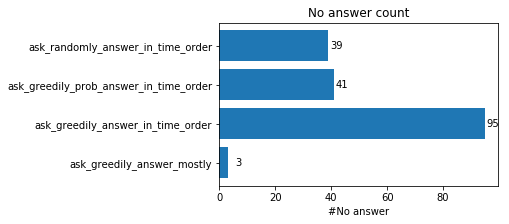

*************Criterion: sum_dirichlet_variances*************


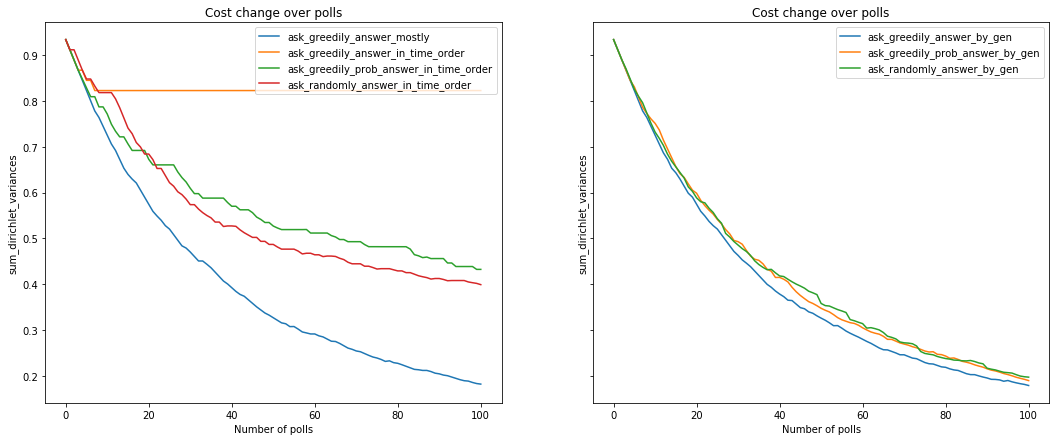

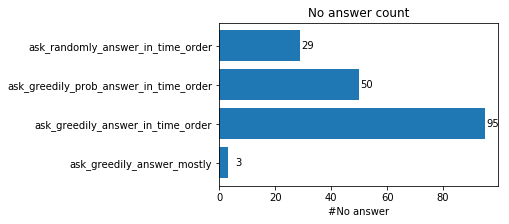

In [54]:
criterion_to_weights = {
    'sum_dirichlet_variances': [(None, None)],
    'weighted_sum_dirichlet_variances': \
        [(dataset_profile.ave_num_feature_ratings_per_product, \
              dataset_profile.global_ave_sum_variances)
        ]
}

product = None
for criterion in Feature.criteria:
    for weights in criterion_to_weights[criterion]:
        prior_count, prior_cost = weights              
        product_to_result_stats = reviews_soli_driver.simulate_reviews_soli(
            file_path, num_polls=num_polls, lower_num_reviews=lower_num_reviews,
            criterion=criterion,
            prior_count=prior_count, prior_cost=prior_cost)

        if not product:
            product = random.choice(list(product_to_result_stats.keys()))    
            print('Product: {}'.format(product))
        sim_stats = product_to_result_stats[product]
        
        criterion_str = criterion
        if prior_count and prior_cost:           
            criterion_str = '{} with prior_count={:.2f}, prior_cost={:.2f}'.format(
                criterion, prior_count, prior_cost)
        print('*' * 13 + 'Criterion: {}'.format(criterion_str) + '*' * 13)
        plot_ask_methods(sim_stats, criterion_str)

        no_answer_counts = [stat.no_answer_count for stat in sim_stats]
        plot_no_answer_count(ReviewsSolicitation.ask_methods[3:], no_answer_counts[3:])